# RAG over complex Documents


## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../../.."
sys.path.append(os.path.abspath(module_path))

## 1. Creatr Bedrock client

In [3]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-G1': 'amazon.titan-text-express-v1',
 'Titan-Text-G1-Light': 'amazon.titan-text-lite-v1'}


## 2. Titan Embedding 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [5]:
from langchain_community.chat_models import BedrockChat
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm_text = BedrockChat(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 1024,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

BedrockChat(client=<botocore.client.BedrockRuntime object at 0x7f213c1121a0>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 1024, 'stop_sequences': ['\n\nHuman']}, streaming=True, callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7f2125953be0>])

### Embedding 모델 선택

In [7]:
from langchain.embeddings import BedrockEmbeddings

In [8]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Embeddings-G1")
)
dimension = 1536
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. LangChainOpenSearch VectorStore 정의
### 선수 조건
- 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 OpenSearch Index 가 생성이 되어 있어야 합니다.
#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.
- 01_preprocess_docs/01_parameter_store_example.ipynb 참고

In [9]:
import boto3
from utils.ssm import parameter_store

In [10]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [11]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [12]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### Index 이름 셋팅
- 이전 노트북 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 생성된 OpenSearch Index name 입력

In [13]:
index_name = opensearch_user_password = pm.get_params(
    key="opensearch_index_name",
    enc=True
)

print (f'index_name: {index_name}')

index_name: summit-workshop-index


### OpenSearch Client 생성

In [14]:
from utils.opensearch import opensearch_utils

In [15]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

## 4. Question Answering
- [BedrockChat with claude3](https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8)

In [16]:
from utils.rag import qa_chain
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

### Retriever 정의

In [85]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    #reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=True, # enable parent document
    
    # option for complex documents consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=5, # 최종 Document 수 정의
    verbose=True,
)

### QA chain 정의

In [86]:
system_prompt = prompt_repo.get_system_prompt()

In [87]:
qa = qa_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    return_context=True,
    verbose=False
)

In [45]:
#query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

#query = "수익률 그래프 설명해줘"
#query = "만기가격이 기준가격의 100% 미만일 때 만기상환금액 계산하는 방법 알려줘"
#query = "전년 동기 현금 예치금 구성비 알려줘"
#query = "자산총계 금액 알려줘"
#query = "대출채권 금액은?"

#query = "대출채권의 전년동기에 해당하는 구성비는 얼마입니까?"
#query = "당기손익-공정가치측정유가증권 전년동기의 구성비는?"

query = "재난 발생 시 대처사항은?"
query = "학교폭력 처리 과정은?"
query = "감염병의 종류와 경로는?"
query = "홍역에 대한 백신 이름은?"
query = "MMR 2차의 예방접종 시기는?"
query = "교육목표는?"

response, contexts = qa.invoke(
    query = query,
    verbose=False
)

show_context_used(contexts)

===== ParentDocument =====
filter: [{'bool': {'should': [{'term': {'metadata.family_tree': 'child'}}, {'term': {'metadata.family_tree': 'parent_table'}}, {'term': {'metadata.family_tree': 'parent_image'}}]}}]
# child_docs: 8
# parent docs: 8
# duplicates: 0
##############################
async_mode
##############################
True
##############################
reranker
##############################
False
##############################
rag_fusion
##############################
False
##############################
HyDE
##############################
False
##############################
parent_document
##############################
True
##############################
complex_document
##############################
True
##############################
similar_docs_semantic
##############################

Score: 1.0
['. 나. 학생의 학습 수준을 확인하고 결과만이 아니라 결과에 이르기까지의 학습과정을 중시한다. 다. 학생의 학습 과정과 결과에 대한 맞춤형 피드백을 제공하여 학생의 학습을 지원한다. 라. 평가의 목표를 학생에게 미리 안내(매 학기 초 사전 안내)하여 학습 과정에서 학생이 주도적으로 자신의 학습과정을 성찰

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f21102e5990>

### Parameter updates

In [112]:
opensearch_hybrid_retriever.update_search_params(
    k=8,
    minimum_should_match=0,
    
    # hybird-search debugger
    hybrid_search_debugger = "None", #[lexical, semantic, None]
    
    # filter=[
    #     {'term': {'metadata.family_tree': 'child'}},
    # ],
    
    parent_document=False, # enable parent document
    
    ensemble_weights=[0.51, 0.49], #semantic, lexical
    verbose=False
)

In [113]:
#query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

##
query = "학기 초에 어린이 납치 예방 방법은?" # semantic o, lexical x
#query = "차 흡연 옷. 벽면에 붙은 연기로 인한 피해?" # semantic o, lexical x


In [114]:
response, contexts = qa.invoke(
    query = query,
    verbose=False
)

신학기를 대비하여 실종 유괴 예방 수칙은 다음과 같습니다.

1) 비상시를 대비하여 자녀의 새 친구, 주변 사람들의 연락처를 미리 파악한다.
2) 부모의 허락 없이 낯선 사람의 차에 타지 않도록 하며, 얼굴을 아는 사람이어도 함부로 따라가지 않도록 교육한다.  
3) 자녀의 이름, 전화번호를 옷 안, 신발 안, 가방 안쪽 등 보이지 않는 곳에 써둔다.
4) 다른 사람을 통해서는 어떠한 경우에도 아이를 데려오게 하거나 심부름시키지 않는다는 것을 강조한다.
5) 도로와 떨어져서 인도 안쪽으로 걷는 습관을 기르도록 교육한다.
6) 통학로의 우범지역과 사각지대를 파악하여 아이에게 위험한 곳임을 미리 알려준다.
7) 모르는 사람에게 예의 바르게 행동하는 것보다는 자신의 안전을 지키는 것이 우선임을 강조한다.  
8) 자녀들이 스스로 자신을 보호할 수 있도록 실종예방수칙(안돼요! 싫어요! 도와주세요!)을 반복해서 지도한다.

##################################
query:  학기 초에 어린이 납치 예방 방법은?
##################################


### Answer ###
신학기를 대비하여 실종 유괴 예방 수칙은 다음과 같습니다.

1) 비상시를 대비하여 자녀의 새 친구, 주변 사람들의 연락처를 미리 파악한다.
2) 부모의 허락 없이 낯선 사람의 차에 타지 않도록 하며, 얼굴을 아는 사람이어도 함부로 따라가지 않도록 교육한다.
3) 자녀의 이름, 전화번호를 옷 안, 신발 안, 가방 안쪽 등 보이지 않는 곳에 써둔다.
4) 다른 사람을 통해서는 어떠한 경우에도 아이를 데려오게 하거나 심부름시키지 않는다는 것을 강조한다.
5) 도로와 떨어져서 인도 안쪽으로 걷는 습관을 기르도록 교육한다.
6) 통학로의 우범지역과 사각지대를 파악하여 아이에게 위험한 곳임을 미리 알려준다.
7) 모르는 사람에게 예의 바르게 행동하는 것보다는 자신의 안전을 지키는 것이 우선임을 강조한다.
8) 자녀들이 스스로 자신을 보호할 수 있도록 실종예방수칙(안돼요! 싫어요! 도와주세요!)을 반복해서 지도한다.


### Contexts ###

-----------------------------------------------
1. Category: CompositeElement, Chunk: 120 Characters
-----------------------------------------------
133. 생명존중교육 ◦자살예방교육 및 예방활동 실시 ◦교과 및 창체 연계 생명존중교육, 환경지킴 연중 1~6학년 생활인권 이 교육 실시 - 2 - 록(綠) 2. 몸과 마음이
건강하고 예술을 향유하는 문화적인 어린이
metadata:
 {'source': './data/complex_pdf/school_edu_guide.pdf', 'filetype': 'application/pdf', 'languages':
['kor', 'eng'], 'last_modifi

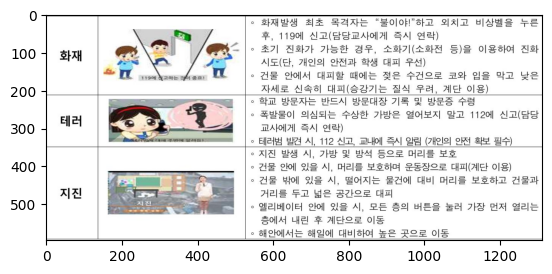

이미지는 한국 전통 놀이문화인 "투호놀이", "제기차기", "지진바둑" 등을 소개하고 있습니다. 각 놀이의 규칙과 방법을 설명하는 그림과 글로 구성되어 있습니다. 이러한 전통
놀이들은 한국의 문화유산이며, 어린이들에게 재미와 전통문화를 익힐 수 있는 기회를 제공합니다.
metadata:
 {'img_path': './fig/figure-34-74.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'd83f83e8-0128-421b-b0e1-4a39979bec5e', 'origin_image': ''}

-----------------------------------------------
6. Category: CompositeElement, Chunk: 932 Characters
-----------------------------------------------
. 출입지점 관리 사 로 1) 학생은 정해진 보행로로 등하교: 차량 출입이 많은 경사로는 학생 출입 통제 을 2) 등하교 학생을 위해 교내 외부 차량(학부모 차량 포함) 진입
금지, 교문 앞 주․정차 금지 3) 학생들의 교육활동 시간에는 외부인(학부모 포함)을 통제 ① 방문객은 배움터지킴실에서 관리대장에 성명 및 방문목적을 기재하고 방문증을 교부받는다.
(신분증 지참) ② 교내에서는 반드시 방문증을 패용하고 용무 후에는 방문증을 배움터지킴이실에 반납한다. 2. 유괴 예방 가. 신학기 대비 실종 유괴 예방 수칙 1) 비상시를
대비하여 자녀의 새 친구, 주변 사람들의 연락처를 미리 파악한다. 2) 부모의 허락 없이 낯선 사람의 차에 타지 않도록 하며, 얼굴을 아는 사람이어도 함부로 따라가지 않도록
교육한다. 3) 자녀의 이름, 전화번호를 옷 안, 신발 안, 가방 안쪽 등 보이지 않는 곳에 써둔다. 4) 다른 사람을 통해서는 어떠한 경우에도 아이를 데려오게 하거나 심부름시키

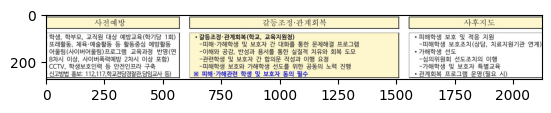

이미지는 사전예방, 간동조정 및 개입, 사후지도에 대한 내용을 표로 설명하고 있습니다. 사전예방 관련해서는 학생 학부모 교직원 대상 예방교육, 도래활동, 재능 개출활동 등의
활동으로써 예방할 수 있음을 제시합니다. 간동조정 및 개입 부분에서는 관계회복, 가해학생 및 보호자 간 대화를 통한 문제해결 프로그램 등의 내용이 있습니다. 마지막으로
사후지도에서는 피해학생 보호 및 지원, 가해학생 선도, 전문상담위원회 설도조치 등의 내용이 기술되어 있습니다.
metadata:
 {'img_path': './fig/table-28.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '9764043a-dd06-4947-ba86-0ce145084b73', 'origin_image': ''}

-----------------------------------------------
8. Category: Image, Chunk: 176 Characters
-----------------------------------------------


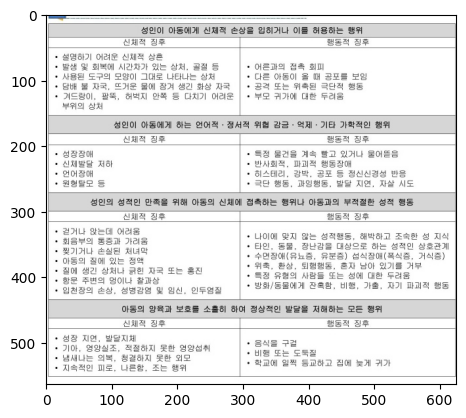

이미지는 어린이와 청소년의 인터넷 사용 시 발생할 수 있는 위험 요소들과 대처 방안을 정리한 표입니다. 인터넷 과의존, 불법정보 유통, 사이버 폭력, 개인정보 노출 등의 위험
요인과 예방법 및 대처법을 제시하고 있습니다. 아동과 청소년의 안전한 인터넷 이용을 위한 가이드라인을 체계적으로 정리하여 보여주고 있습니다.
metadata:
 {'img_path': './fig/table-27-resize.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'cc11493b-c09a-4305-9d7d-b295e2335c20', 'origin_image': ''}


In [115]:
print("##################################")
print("query: ", query)
print("##################################")

print (colored("\n\n### Answer ###", "blue"))
print_ww(response)


print (colored("\n\n### Contexts ###", "green"))
show_context_used(contexts, limit=10)